## Escuela de Ingeniería en Computación, ITCR 
## Aprendizaje automático
## Redes de memoria de corto y largo plazo (LSTM)
## Clasificación multi-clase 

**Profesora: María Auxiliadora Mora**

La clasificación de textos permite categorizar el contenido asociando este a una etiqueta predefina o clase. Su uso más popular es el **análisis de sentimientos**. 

Ejemplo:

- En mi opinión, la película fue muy buena porque pudo dar a conocer a los espectadores cómo puede afectar una situación traumática a la mente humana. (Clase = 5 o excelente).

Las redes neuronales recurrentes o RNN (Rumelhart et al., 1986, como se citó en LeCun et al., 2015) son una familia de redes neuronales para el procesamiento de secuencias de datos, las cuales en un tiempo t, reciben el estado anterior, es decir, su salida en el tiempo t podría usarse como insumo del procesamiento de la siguiente entrada, de modo que la información pueda propagarse a medida que la red pasa por la secuencia de entrada. Las redes Long Short-Term Memory (LSTM) son un tipo de red neuronal recurrente capaz de aprender dependencias a largo plazo.

El siguiente ejemplo basado en [1] permite clasificar comentarios sobre prendas de vestir utilizando una red LSTM.

Definición del problema: dado el comentario de revisión de una prenda de vestir, se desa predecir la calificación de la opinión del usuario. Las clases a utilizar son valores enteros del 1 al 5, correspondiendo el 1 a la peor clase y 5 a la mejor.

![Imagen: B&H](../imagenes/rate_survey.png "Clases a predecir")
[Imagen: B&H]

Los datos utilizado en el ejemplo están disponibles en https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews. La descripción del sitio indica "este es un conjunto de datos de comercio electrónico de ropa de mujer que presenta reseñas escritas por los clientes." 

El conjunto de datos consta de las siguientes columnas: 
- Clothing ID: Integer variable that refers to the specific piece being reviewed.
- Age: Positive Integer variable of the reviewers age.
- Title: String variable for the title of the review.
- Review Text: String variable for the review body.
- Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
- Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
- Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.
- Division Name: Categorical name of the product high level division.
- Department Name: Categorical name of the product department name.
- Class Name: Categorical name of the product class name.

Se realizarán los siguientes pasos

   * Leer los datos de ejemplo
   * Preprocesar los textos a clasificar
   * Definir el modelo
   * Instanciar el modelo, definir la función de pérdida y el optimizador a utilizar  
   * Entrenar la red
   * Probar el modelo resultante

In [ ]:
#!pip install spacy
#!pip install seaborn

In [2]:
# Bibliotecas requeridas

# básicas
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
import string

# Scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn import metrics

# torch 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Crea un pipeline vacío para un tipo de idioma. 
tok = spacy.blank("en")

## Demostración de uso de las capas LSTM y Embbeding 

In [59]:
# Las palabras se deben codificar antes de pasarlas a la red
x = torch.tensor([[28,65,22,99,98,73,33,6],
                  [43,65,67,32,22,68,6,2],
                  [45,67,97,44,80,22,67,98]])


In [60]:
# primero las palabras se vectorizan

# Funcionamiento de la capa de vectorización
vocab_size = 100 
# tamaño del vector que representa las palabras
embedding_dim = 7 
embedding_layer = nn.Embedding(vocab_size, embedding_dim)

# capa del LSTM
# tamaño del vector de estado
hidden_size=3   
# si el primer elemento del shape de la entrada corresponde al tamaño del lote
batch_first=True

LSTM_layer = nn.LSTM(embedding_dim, hidden_size, num_layers=1, batch_first=True)

In [61]:
out1 = embedding_layer(x)
out2 = LSTM_layer(out1)

print(out1)

tensor([[[-9.3592e-01,  1.0864e+00,  4.4626e-02, -1.1434e+00, -4.8425e-01,
          -7.7314e-02, -4.8152e-03],
         [-1.1868e-01, -4.9572e-02,  7.1555e-01, -1.0939e+00,  6.2109e-01,
           9.2093e-01, -8.4383e-01],
         [-9.2588e-01,  4.5266e-01,  1.1159e-01,  6.9972e-02,  1.1630e+00,
           9.5163e-01, -1.4769e+00],
         [ 1.6167e+00,  8.5779e-01,  1.9423e-01,  1.8401e-01,  6.7044e-01,
          -4.5609e-01, -6.7405e-01],
         [-1.3322e+00,  1.2790e+00,  1.7828e+00, -4.3517e-01,  7.6790e-01,
          -1.4021e+00, -1.2237e+00],
         [ 1.3437e+00,  2.7453e-02, -1.2484e+00,  2.8740e-01,  1.6455e+00,
           2.0674e+00, -1.8308e-01],
         [ 5.4694e-01, -9.7677e-01,  6.1395e-01, -3.5244e-01,  9.7607e-01,
           2.0494e-01, -7.6475e-01],
         [-7.2302e-01,  6.4453e-01, -9.3325e-01, -3.0263e-01,  7.9630e-01,
          -1.8444e-02,  1.1912e+00]],

        [[-1.3825e+00, -1.0811e+00,  1.9007e-01,  1.1008e-01, -9.9590e-01,
          -1.2702e+00, -1.2

La capa LSTM genera tres cosas:

 - La salida consolidada — de todos los estados ocultos en la secuencia
 - Estado oculto de la última unidad LSTM: la salida final
 - La celda de estado
 
 3x8 -> embedding_layer -> 3x8x7 -> LSTM_layer (con hidden size=3)-> 3x3

In [62]:
out, (ht, ct) = LSTM_layer(out1)
print(ht)

tensor([[[ 0.4209,  0.2667,  0.1295],
         [ 0.3715, -0.0775,  0.0047],
         [-0.0393,  0.2871, -0.0703]]], grad_fn=<StackBackward0>)


## Exploración y preprocesamiento de los datos

In [63]:
# Leer los datos de ejemplos
reviews = pd.read_csv("../../Data/clothing_reviews.csv")

#reviews = pd.read_csv("../Data/clothing_reviews.csv")

print(reviews.shape)
reviews.head()

(23486, 11)


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [64]:
# Funciones utilitarias

def text_preprocesing(reviews):
    """
    Preprocesamiento del texto para concatenar los campos 'Title' y 'Review Text',
    eliminar los registros con datos nulos y renumerar las clases.
    Parámetros:
       reviews: daaframe con el texto a procesar
    """
    # Revisión de contenidos nulos y otros
    reviews['Title'] = reviews['Title'].fillna('')
    reviews['Review Text'] = reviews['Review Text'].fillna('')

    # Se concatena los campos Title y Review Text.
    reviews['review'] = reviews['Title'] + ' ' + reviews['Review Text']
    
    # Seleccionar las columnas relevantes y calcular la longitud 
    # de las oraciones en número de palabras.
    reviews = reviews[['review', 'Rating']]
    reviews.columns = ['review', 'rating']
    reviews['review_length'] = reviews['review'].apply(lambda x: len(x.split()))
 
    # Eliminar registros con review vacío y rating igual a cero
    print("Cantidad de registros antes de la limpieza", reviews.shape)
    reviews= reviews[reviews['review_length'] != 0]
    reviews = reviews[pd.notnull(reviews['rating'])]
    reviews= reviews[reviews['rating'] != 0]
    print("Cantidad de registros después de la limpieza", reviews.shape)
    
    #Cambio de la numeración de la clasificaciones de 0 a 4
    zero_numbering = {1:0, 2:1, 3:2, 4:3, 5:4}
    reviews['rating'] = reviews['rating'].apply(lambda x: zero_numbering[x])
    
    return reviews

def tokenize (text):
    """
    Realiza la tokenización: proceso de separar un fragmento de texto en 
    unidades más pequeñas llamadas tokens. 
    Los tokens pueden ser palabras, caracteres o sub-palabras.
    """
    # remueve caracteres especiales
    text = re.sub(r"[^\x00-\x7F]+", " ", text) 
    # remueve signos de puntuación y números
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') 
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]


def delete_nonfrequent_terms(reviews):
    """
    Elimina los tokens que no ocurren con mucha frecuencia (menos de dos veces). 
    Retorna
      counts: un diccionario con los tokens a tomar en cuenta.
    """
    print("=================== Conteo de términos ====================")
    # cuenta frecuencia de términos
    counts = Counter()
    for index, row in reviews.iterrows():
        counts.update(tokenize(row['review']))
    print(counts)  
    print("=================== Términos no frecuentes ====================")
    print("num_words before:",len(counts.keys()))
    for word in list(counts):
        if counts[word] < 2:
            del counts[word]
    print("num_words after:",len(counts.keys()))
    print(counts)
    return counts

def create_vocabulary(counts):
    """
    Crea el vocabulario a partir del diccionario counts.
    Retorna: 
       vocab2index: diccionario con el vocabulario.
       words: lista de palabras.
    """
    print("=================== Crear vocabulario ====================")   
    vocab2index = {"":0, "UNK":1}
    words = ["", "UNK"]
    # crea un diccionario de tokens, le asigna un código a cada token.
    for word in counts:
        vocab2index[word] = len(words)
        words.append(word)
    return vocab2index, words

def encode_sentence(text, vocab2index, N=70):
    """
    Codificación de una oración antes de ser utilizada por el modelo. 
    Parámetros:
       text: el texto a procesar
       vocab2index: diccionario con el vocabulario a utilizar. 
       N: largo máximo
    """
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    
    # get de diccionario permite definir un valor si un item no existe ("UNK").  
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    
    # Largo máximo del resultado.
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

class ReviewsDataset(Dataset):
    """
    Define la clase Dataset para manejo de los datos
    """
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx]

In [65]:
print(tokenize("Hola esta es una prueba."))

['hola', 'esta', 'es', 'una', 'prueba']


In [66]:
# preprocesar los textos
reviews = text_preprocesing(reviews)

# borrar los términos poco frecuentes
counts = delete_nonfrequent_terms(reviews)

# crear el vocabulario 
vocab2index, words = create_vocabulary(counts)
print(vocab2index)  

/tmp/ipykernel_3889/3435115452.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['review_length'] = reviews['review'].apply(lambda x: len(x.split()))


Cantidad de registros antes de la limpieza (23486, 3)
Cantidad de registros después de la limpieza (22642, 3)
=================== Conteo de términos ====================
Counter({' ': 141771, 'the': 77216, 'i': 67652, 'and': 50853, 'it': 50036, 'a': 44076, 'is': 30994, 'this': 26693, 'to': 25159, 'in': 21343, 'but': 18130, '  ': 17445, 'on': 15679, 'for': 15114, 'of': 13695, 'with': 13105, 'so': 12703, 'was': 12299, 'dress': 12221, 'my': 11288, 'not': 10976, 'love': 10819, 'that': 10089, 't': 9198, 's': 9191, 'size': 8978, 'very': 8857, 'top': 8595, 'have': 8159, 'fit': 7939, 'great': 7908, 'like': 7388, 'are': 7361, 'be': 7131, 'me': 7065, 'as': 6905, 'm': 6838, '   ': 6739, 'wear': 6556, 'too': 6553, 'you': 5917, 'or': 5915, 'just': 5834, 'am': 5758, 'they': 5422, 'would': 5139, 'fabric': 5082, 'small': 5069, 'up': 5008, 'color': 4916, 'at': 4896, 'cute': 4596, 'perfect': 4590, 'beautiful': 4372, 'can': 4321, 'look': 4147, 'if': 4085, 'really': 4075, 'more': 4042, '    ': 4036, 'flat

In [68]:
# Codificación de los textos
reviews['encoded'] = reviews['review'].apply(lambda x: np.array(encode_sentence(x,vocab2index ), dtype=object))
print(reviews.head())

                                              review  rating  review_length  \
0   Absolutely wonderful - silky and sexy and com...       3              8   
1   Love this dress!  it's sooo pretty.  i happen...       4             62   
2  Some major design flaws I had such high hopes ...       2            102   
3  My favorite buy! I love, love, love this jumps...       4             25   
4  Flattering shirt This shirt is very flattering...       4             38   

                                             encoded  
0  [[2, 3, 4, 5, 6, 7, 8, 7, 9, 0, 0, 0, 0, 0, 0,...  
1  [[2, 10, 11, 12, 5, 13, 14, 15, 16, 5, 17, 18,...  
2  [[54, 55, 56, 57, 17, 58, 59, 60, 61, 62, 11, ...  
3  [[68, 109, 110, 2, 17, 10, 2, 10, 2, 10, 11, 1...  
4  [[122, 123, 11, 123, 52, 92, 122, 19, 124, 125...  


In [69]:
# Verificación de qué tan bien balanceadas están las clases.
Counter(reviews['rating'])

Counter({4: 12541, 3: 4908, 2: 2823, 1: 1549, 0: 821})

In [71]:
# datos de interés
X_data = list(reviews['encoded'])
y_data = list(reviews['rating'])

# división de los datos de entrenamiento y pruebas.
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2)

# Creación de los datasets de entrenamiento y validación
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [57]:
#print(X_train[1-10:])
print(y_train)

[4, 2, 2, 3, 4, 2, 1, 4, 4, 4, 4, 4, 4, 4, 3, 0, 3, 4, 4, 2, 4, 4, 0, 3, 4, 4, 3, 4, 4, 3, 4, 4, 2, 4, 3, 4, 4, 0, 1, 3, 2, 4, 4, 0, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 3, 4, 3, 1, 2, 4, 4, 4, 4, 3, 4, 4, 2, 2, 3, 4, 3, 2, 4, 4, 4, 0, 3, 4, 2, 4, 3, 4, 3, 3, 3, 4, 3, 2, 3, 2, 0, 4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 2, 3, 4, 4, 4, 1, 4, 0, 2, 4, 2, 2, 1, 4, 4, 1, 1, 4, 1, 4, 4, 4, 0, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 3, 3, 4, 0, 4, 2, 3, 4, 4, 4, 3, 0, 4, 2, 2, 3, 3, 1, 4, 3, 1, 3, 4, 3, 4, 4, 1, 3, 4, 3, 3, 4, 4, 3, 4, 4, 2, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 3, 2, 2, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 3, 4, 4, 4, 3, 4, 3, 4, 4, 4, 1, 3, 4, 1, 4, 4, 4, 4, 4, 3, 1, 4, 3, 3, 3, 4, 2, 2, 1, 4, 3, 0, 2, 3, 4, 3, 3, 4, 4, 4, 0, 4, 1, 2, 1, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 1, 3, 4, 2, 0, 3, 3, 4, 4, 4, 4, 4, 1, 2, 3, 4, 2, 4, 4, 3, 4, 4, 4, 4, 3, 1, 3, 4, 2, 4, 4, 3, 1, 3, 4, 3, 2, 3, 4, 1, 2, 4, 4, 3, 3, 4, 2, 4, 2, 4, 4, 4, 2, 2, 4, 4, 3, 4, 3, 3, 

##  Definición y entrenamiento del modelo


In [72]:
class LSTM_fixed_len(torch.nn.Module) :
    """
    Clase para realizar la clasificación de las oraciones. 
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size=5) :
        """
        Inicialización de la clase.
        Parámetros:
           embedding_dim: dimensionalidad del vector de palabras. 
           hidden_dim: dimensión de la capa oculta de la red. 
           vocab_size: tamaño del vocabulario.  
           tagset_size: número de clases.
        """
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, tagset_size)
        
        # Durante el entrenamiento, pone a cero aleatoriamente algunas de las conexiones 
        # de la red con probabilidad p utilizando muestras de una 
        # distribución de Bernoulli. Esta ha demostrado ser una técnica eficaz para la regularización.
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])
    
    
def train_model(model, train_dl, val_dl, epochs=10, lr=0.001):
    """
    Entrenamiento del modelo utilizando PyTorch.
    Parámetros:
       model: una instancia del modelo. 
       epochs: número de épocas de entrenamiento. 
       lr: factor de aprendizaje
    """
    # Selección del optimizador
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    
    # Para todas las épocas
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y in train_dl:
            x = x.long()
            y = y.long()
            
            # se realiza la predicción.
            y_pred = model(x)
            optimizer.zero_grad()
            
            # se calcula la pérdida
            loss = F.cross_entropy(y_pred, y)
            
            # cálculo del gradiente
            loss.backward()
            
            # actualización de los parámetros
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse, predicted, y_test = validation_metrics(model, val_dl)
        if i % 5 == 1:
           print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))

def validation_metrics (model, valid_dl):
    """
    Validación del modelo utilizando PyTorch.
    Parámetros:
       model: una instancia del modelo. 
       valid_dl: DataLoader con acceso a datos de validación.
    """    
    predicted = torch.Tensor([])
    y_test = torch.Tensor([])

    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y in valid_dl:
        x = x.long()
        y = y.long()
        # Se realiza la predicción
        y_hat = model(x)
        # Se calcula la pérdida
        loss = F.cross_entropy(y_hat, y)
        
        # conteo de los casos correctamente clasificados
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        # casos totales
        total += y.shape[0]
        
        predicted = torch.cat((predicted, pred))
        y_test = torch.cat((y_test, y))

        
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total, predicted, y_test  

def plot_confusion_matrix(y_test, predicted):    
    """
    Displays the confusion matrix and other metrics.
    
    Parameters:
      y_test : a list of test data. 
      predicted: a list of model results
    """
    classes = np.unique(y_test)
    
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)

    print("Accuracy:",  round(accuracy,2))
    print("Details:")
    print(metrics.classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    plt.show()

In [74]:
# entrenamiento del modelo
batch_size = 5000
vocab_size = len(words)

# definición de los dataloaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

embedding_dim = 100
hidden_dim = 200

model_fixed =  LSTM_fixed_len(vocab_size, embedding_dim, hidden_dim)
train_model(model_fixed, train_dl, val_dl, epochs=30, lr=0.01)

train loss 1.321, val loss 1.296, val accuracy 0.552, and val rmse 1.388
train loss 1.201, val loss 1.229, val accuracy 0.552, and val rmse 1.386
train loss 1.153, val loss 1.239, val accuracy 0.538, and val rmse 1.362
train loss 0.965, val loss 1.071, val accuracy 0.573, and val rmse 1.023
train loss 0.918, val loss 1.071, val accuracy 0.567, and val rmse 1.025
train loss 1.222, val loss 1.263, val accuracy 0.548, and val rmse 1.390


Exactitud tensor(0.5235)
Raíz del error cuadrático medio 1.3586324349055199
Accuracy: 0.52
Details:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       173
         1.0       0.00      0.00      0.00       296
         2.0       0.23      0.02      0.03       576
         3.0       0.19      0.07      0.10       986
         4.0       0.56      0.92      0.69      2498

    accuracy                           0.52      4529
   macro avg       0.20      0.20      0.16      4529
weighted avg       0.38      0.52      0.41      4529



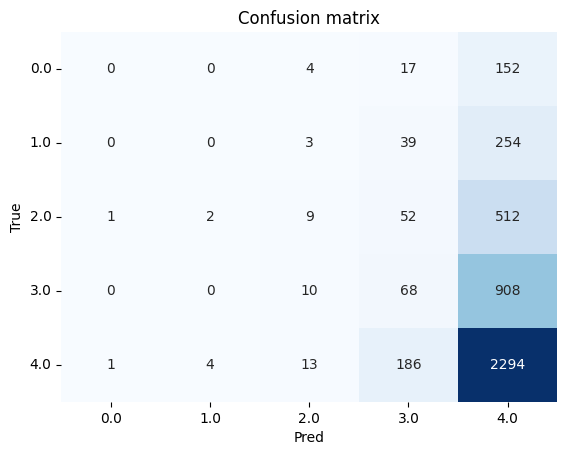

In [75]:
# Validación del modelo 
average_loss, accuracy, average_rmse, predicted, y_test = validation_metrics (model_fixed, val_dl)

print ("Exactitud", accuracy)
print("Raíz del error cuadrático medio", average_rmse)

# Evaluate model performance
plot_confusion_matrix(y_test, predicted)

## Evaluación de resultados

- Las métricas indican que el modelo no logra buenos resultados. 

- Existen varios elementos a explorar como:

   - Las clases están evidentemente desbalanceadas como se muestra en el siguiente diccionario { 4: 12541, 3: 4908, 2: 2823, 1: 1549, 0: 821}. Es muy importante balancear las clases para lograr mejorar los resultados. Podría utilizarse métodos automáticos de balanceo de clases o podría decidirse juntar los elementos de algunas clases.
   
   - Podría procesarse un poco más el vocabulario.


## Referencias y otros materiales
[1] Aakanksha, N. (2020). Multiclass Text Classification using LSTM in Pytorch. Recuperado de https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df
o https://jovian.ml/aakanksha-ns/lstm-multiclass-text-classification/v/5?utm_source=embed

[2] Bishop, C (2006). Pattern Recognition and Machine Learning. Springer.

[3] Cheng, R. (2020). LSTM Text Classification Using Pytorch. Recuperado de https://www.kaggle.com/code/burhanykiyakoglu/predicting-sentiment-from-clothing-reviews